In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import copy

from tqdm import tqdm
import cv2
from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter1d

import vidutils

## Structure and helpers definition

In [2]:
class limb:

    # `p0` and `p1` are of the form `np.array([x, y])`
    def __init__(this, p0, p1):
        this.p0 = p0
        this.p1 = p1

    # angle between the limb and the vertical line (in radians)
    def angle(this):
        dp = this.p0 - this.p1
        return math.atan2(abs(dp[0]), dp[1])


class body:

    """
    # class members:

    root:       point    # is used only for sorting different bodies in space (point(x, y) is np.array([x, y]))
    limbs:      dict     # mapping {limb_name -> limb_instance}

    limb_nodes: dict     # [static member] mapping {limb_name -> pair of indices of corresponding keypoints}

    """

    limb_nodes = \
    {
        'neck':           (1,  0),

        'right_shoulder': (1,  2),
        'right_forearm':  (2,  3),
        'right_arm':      (3,  4),
        'right_thigh':    (8,  9),
        'right_leg':      (9,  10),

        'left_shoulder':  (1,  5),
        'left_forearm':   (5,  6),
        'left_arm':       (6,  7),
        'left_thigh':     (11, 12),
        'left_leg':       (12, 13)
    }

    # `current_subset` is an element of `subset` for current body;
    # `candidate` is a full list of keypoints returned by `body_estimation`;
    #
    # note: if `current_subset` and/or `candidate` is None the created `body` is 'empty':
    #       `limbs` will contain every limb name but all of them will map to `None`
    #
    def __init__(this, candidate = None, current_subset = None):

        #helper functions
        
        # index `idx` represents a keypoint in `current_subset`;
        # returns an array of the form `[x, y]`
        #
        # note: if the keypoint refered to by `idx` is absent
        #       returns `None`
        #
        def get_point_by_index(idx):

            if current_subset is not None and candidate is not None:

                # remapping 'index of a keypoint' -> 'index of the corresponding keypoint coordinates'
                idx = int(current_subset[idx])

                if idx == -1:
                    return None
                else:
                    return candidate[idx][0:2]
            else:
                return None

        # returns a `limb` constructed using points refered by keypoint indices `idx1` and `idx2`:
        # 
        #  -> limb(p1, p2)
        #
        #  where:
        #         `p1` and `p2` are of the form `[x, y]` and denote a keypoint position
        #
        #  note: if any of the keypoints refered to by `idx1` or `idx2` is absent
        #        returns `None`
        #
        def create_limb(idx1, idx2):
           
            p1 = get_point_by_index(idx1)
            p2 = get_point_by_index(idx2)

            if p1 is None or p2 is None:
                return None
            else:
                return limb(p1, p2)

        #------------------------------------------------------------------------

        # the body root is assumed to be the keypoint 1 (bottom of the neck)
        this.root = get_point_by_index(1)
        
        this.limbs = {}

        for limb_name in body.limb_nodes:
            
            l = create_limb(*body.limb_nodes[limb_name])

            if l is not None:
                this.limbs[limb_name] = l


class dancer:

    """
    # class members:

    limbs: dict     # mapping {limb_name -> angle(time)}

    """

    # `body_instances` is an array of different time instances of `body` for a particular dancer
    # (some of the instances may be missing (~ None-like objects) so that `body_instances` is alligned with the `timeline`)
    #
    # `timeline` is an array containing time moment for each element of `body_instances`;
    # (`timeline` and `body_instances` are required to have the same length)
    #
    # note: if no `timeline` is present it is created as a range(len(`body_instances`))
    #
    def __init__(this, body_instances, timeline):

        this.limbs = {}

        if len(body_instances) > 0:

            if len(timeline) != len(body_instances):
                raise Exception('`timeline` and `body_instances` are of unequal length') 

            # initilizing `this.limbs`
            for limb_name in body.limb_nodes:
                this.limbs[limb_name] = []

            # collecting all the angles for each limb throughout all the instances
            for k in range(len(body_instances)):

                body_instance = body_instances[k]

                if body_instance:

                    for limb_name in body_instance.limbs:

                        l = body_instance.limbs[limb_name]
                        this.limbs[limb_name].append((timeline[k], l.angle()))
                    #end
                #end
            #end

            # at this point `this.limbs` is a mapping
            # from `limb_name` to a list of tuples of the form (t, angle_of_`limb_name`_at_moment_t)

            # now converting each array of points into an interpolation function:
            #
            for limb_name in list(this.limbs):

                p = this.limbs[limb_name]
                
                if len(p) > 0:
                    # first, check that `p` contains endpoints;
                    # otherwise extrapolation should be used
                    # but the data is not enough for more or less 'correct' extrapolation
                    #
                    if p[0][0] == timeline[0] and p[-1][0] == timeline[-1]:
                        
                        # unpacking
                        x, y = zip(*p)

                        # smoothing
                        y = gaussian_filter1d(y, 0.018*len(y))

                        # creating approximation
                        this.limbs[limb_name] = interpolate.CubicSpline(x, y)

                    else:
                        # not enough data to approximate
                        del this.limbs[limb_name]
                else:
                    # no data to approximate -> erasing an element from the dictionary
                    del this.limbs[limb_name]

                #endif
            #end
        #endif

    # operator[](limb_name) -> spline
    def __getitem__(this, limb_name):
        return this.limbs[limb_name]


Helper functions for convenient creation of `dancer` instances:

In [3]:
# meta-helpers ======================================================================================


# create bodies from frames in `frames_dir`;
# returns:
#
#    1. a list of arrays of bodies in each frame
#    2. the corresponding timeline
#    3. total number of dancers detected throughout the frame sequence
#       (as some dancers may appear/leave the scene or just failed to be detected)
#
def create_bodies_from_frames(body_estimation, frames_dir, frame_name_template):

    frames_dir = os.path.normpath(frames_dir) + os.sep

    # reading or creating the timeline:

    try:

        # if file exists -> loading
        timeline = np.load(frames_dir + 'timeline.npz')['timeline']

    except:
        # otherwise creating a default timeline based on the contents of the `frames_dir`
        # (counting the files with the same extension as in `frame_name_template(0)`)

        ext = lambda name: name.split('.')[1].lower()

        template_ext = ext(frame_name_template(0))
        n_frames = len(list(filter(lambda name: ext(name) == template_ext, os.listdir(frames_dir))))

        timeline = range(n_frames)
        
    #----------------------------------------------------------------------

    # list of lists of bodies detected in each frame:
    #
    #   note: body order is arbitrary!
    #
    bodies_unordered = []

    # used for counting the number of individual dancers
    n_dancers = 0

    for i in tqdm(range(len(timeline))):

        img = cv2.imread(frames_dir + frame_name_template(i))
        candidate, subset = body_estimation(img)
        
        # creating bodies:

        res = []

        # iterating over all the detected bodies
        for n in range(len(subset)):

            b = body(candidate, subset[n])

            # if the created body has at least one limb of interest and root initialized
            if b.limbs and b.root is not None:
                res.append(b)

        bodies_unordered.append(res)
        n_dancers = max(n_dancers, len(res))

    #end

    return bodies_unordered, timeline, n_dancers


# match body instances in `bodies_unordered` (using the fact that `n_dancers` individual dancers were detected);
# returns an array `bodies` such that:
#
#    bodies[n] - array of all the body instances for n-th dancer
#
def track_bodies(bodies_unordered, timeline, n_dancers):

    # helpers:

    # a dummy NoneType-like class for denoting points of intersection of bodies' trajectories
    class ConflictPoint:
        def __bool__(this):
            return False

    # returns cosine of the angle between 2 vectors
    #
    def cosine(p1, p2):

        return np.dot(p1, p2)/(np.linalg.norm(p1) * np.linalg.norm(p2))

    #-------------------------------------------------------------------------

    if not bodies_unordered:
        print('track_bodies: `bodies_unordered` is empty')
        return []


    bodies = [[None]*len(timeline) for _ in range(n_dancers)]

    # initial positions and body order are defined by the first frame
    for n in range(n_dancers):

        # however, not all dancers may be present in the first frame
        #
        if n < len(bodies_unordered[0]):
            bodies[n][0] = bodies_unordered[0][n]


    n_frames = len(timeline)

    # skipping the first frame
    for k in range(1, n_frames):

        b_current_frame = bodies_unordered[k]

        # an empty frame -> nothing to update
        if not b_current_frame:
            continue

        # indices of candidates for the next body instances
        candidates = {}

        # choosing the closest body instance for each dancer---------------------------------

        for n in range(n_dancers):

            if bodies[n][k-1]:

                # get the index of the body at frame `k` which is closest to `bodies[n][k-1]`
                #
                idx = min\
                      (
                           range(len(b_current_frame)),
                           key = lambda i: abs(bodies[n][k-1].root[0] - b_current_frame[i].root[0])
                      )

                if idx not in candidates:
                    candidates[idx] = [n]
                else:
                    candidates[idx].append(n)

        # continuing bodies' trajectories----------------------------------------------------

        for idx in candidates:

            if len(candidates[idx]) == 1:

                # only one candidate -> updating
                bodies[candidates[idx][0]][k] = b_current_frame[idx]

            elif len(candidates[idx]) > 1:

                # conflict (intersection of trajectories) -> the current instance cannot be used for any body
                #
                for q in candidates[idx]:
                    bodies[q][k] = ConflictPoint()

                # resolvoing the conflict:

                # if not the last frame...
                if k != n_frames - 1:

                    # ... -> disentangling

                    b_next_frame = bodies_unordered[k+1]

                    if not b_next_frame:
                        continue

                    # yep, during disentanglement new entanglement can appear
                    candidates_with_scores = {}

                    for q in candidates[idx]:

                        x0 = b_current_frame[idx].root[0]
                        p1 = (timeline[k] - timeline[k-1], x0 - bodies[q][k-1].root[0])
                        dt2 = timeline[k+1] - timeline[k]

                        # get the index of the body in frame `k+1`
                        # which gives the best trajectory continuation for `bodies[q][k-1]`
                        #
                        idx = max\
                              (
                                  range(len(b_next_frame)),
                                  key = lambda i: cosine(p1, (dt2, b_next_frame[i].root[0] - x0))
                              )

                        score = cosine(p1, (dt2, b_next_frame[idx].root[0] - x0))

                        if idx not in candidates_with_scores:
                            candidates_with_scores[idx] = [(q, score)]
                        else:
                            candidates_with_scores[idx].append((q, score))

                    # resolving conflicts based on found canditates
                    for idx_s in candidates_with_scores:

                        if len(candidates_with_scores[idx_s]) == 1:

                            q = candidates_with_scores[idx_s][0][0]

                            bodies[q][k+1] = b_next_frame[idx_s]
                            del b_next_frame[idx_s]
                        else:

                            # selecting the instance with maximal score:
                            q, _ = max\
                                   (
                                       candidates_with_scores[idx_s],
                                       key = lambda p: p[1]
                                   )

                            bodies[q][k+1] = b_next_frame[idx_s]
                            del b_next_frame[idx_s]

                            # other instances in `candidates_with_scores[idx_s]` are not updated ->
                            # they remain None -> the corresponding body has disappeared

                else:
                    print('2 bodies seems to be overlapping in the last frame - unable to disentangle')
            #end
        #end

        # checking for unmatched body instances----------------------------------------------

        idx_unmatched = set(range(len(b_current_frame))).difference(candidates)

        if idx_unmatched:

            idx_uninitialized = []

            for n in range(n_dancers):
                
                if bodies[n][k] is None:
                    idx_uninitialized.append(n)
            #end

            if len(idx_uninitialized) != len(idx_unmatched):

                # something strange has happened...
                print('A mismatch between unmatched and uninitialized body instanses in frame {} occured'.format(k))
            else:
                
                for uninitialized, unmatched in zip(idx_uninitialized, idx_unmatched):

                    # updating uninitialized body instances with unmatched ones
                    bodies[uninitialized][k] = b_current_frame[unmatched]
            #end
        #end
    #end

    return bodies


#====================================================================================================

# creates an array of `dancer` objects from frames in `frames_dir` directory
#
# arguments:
#
#    `body_estimation`     - a body estimation model
#    `frames_dir`          - path to a directory to load frames from
#    `frame_name_template` - a function used for creating sequential frame names
#                            (this function is fed with values from range 0..n_frames-1)
#
# return value:
#
#    an array of `dancer` objects for each dancer detected in the frame sequence
#
def create_dancers_from_frames(body_estimation, frames_dir, \
                               frame_name_template = lambda idx: 'frame' + str(idx) + '.jpg'):

    # creating bodies from frames
    bodies_unordered, timeline, n_dancers = create_bodies_from_frames(body_estimation, \
                                                                      frames_dir, \
                                                                      frame_name_template)

    # get an array of ordered bodies
    bodies = track_bodies(bodies_unordered, timeline, n_dancers)

    # creating dancers:

    dancers = []

    for k in range(len(bodies)):

        d = dancer(bodies[k], timeline)

        # if the created dancer has at least one limb of interest initialized
        if d.limbs:
            dancers.append(d)

    return dancers


## Per-limb delay estimation

In [ ]:
# extracting frames (when necessary)

vidutils.extract_frames('videos/video_group7/seg11.mp4', 'sync_measure_data/frames/video_group7/seg11', 40)

In [4]:
bodies_unordered, timeline, n_dancers = create_bodies_from_frames(vidutils.body_estimation, \
                                                                  'sync_measure_data/frames/video_group7/seg11', \
                                                                  lambda idx: 'frame' + str(idx) + '.jpg')

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [05:08<00:00,  7.72s/it]


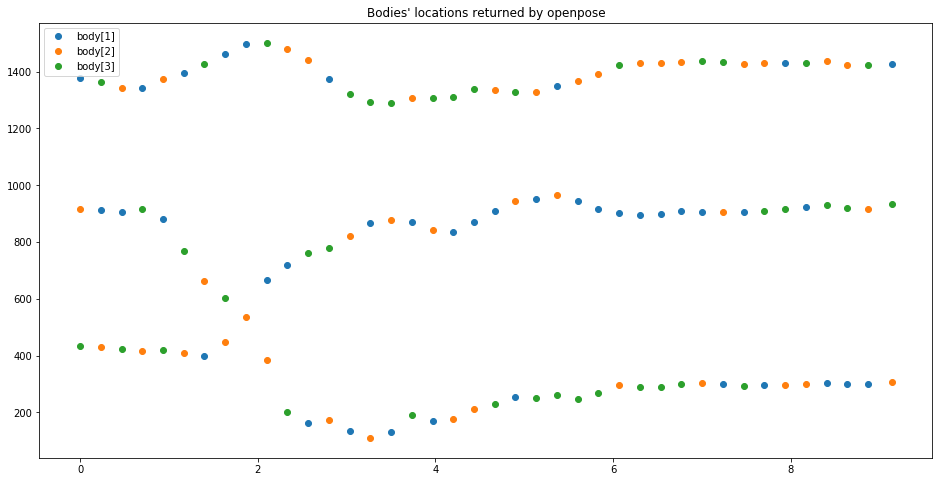

In [61]:
# visualization of `create_bodies_from_frames` output

plt.figure(figsize = (16, 8))

for k in range(n_dancers):

    y = [None]*len(timeline)

    for u in range(len(timeline)):

        if k < len(bodies_unordered[u]) and bodies_unordered[u][k].root is not None:
            y[u] = bodies_unordered[u][k].root[0]

    plt.plot(timeline, y, 'o')

plt.title("Bodies' locations returned by openpose")
plt.legend(['body[' + str(k+1) + ']' for k in range(len(bodies_unordered))])

plt.show()

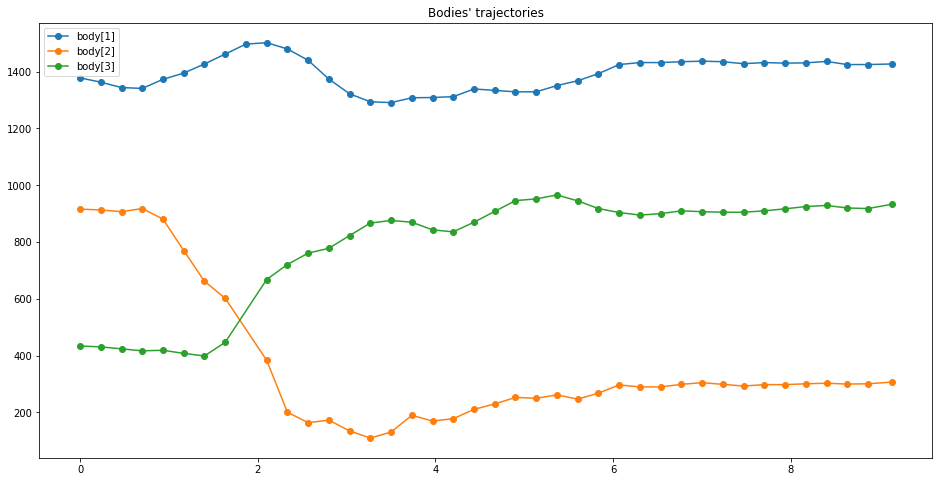

In [15]:
# results of body tracking

bodies = track_bodies(copy.deepcopy(bodies_unordered), timeline, n_dancers)

#-------------------------------------------------------------------------------

plt.figure(figsize = (16, 8))

for k in range(len(bodies)):
      
    y = np.array(list(map(lambda b: np.nan if not b else b.root[0], bodies[k])))
    mask = np.isfinite(y)

    plt.plot(timeline[mask], y[mask], '-o')

plt.title("Bodies' trajectories")
plt.legend(['body[' + str(k+1) + ']' for k in range(len(bodies))])
plt.show()

In [16]:
# creating dancers

dancers = []

for k in range(len(bodies)):

    d = dancer(bodies[k], timeline)

    # if the created dancer has at least one limb of interest initialized
    if d.limbs:
        dancers.append(d)

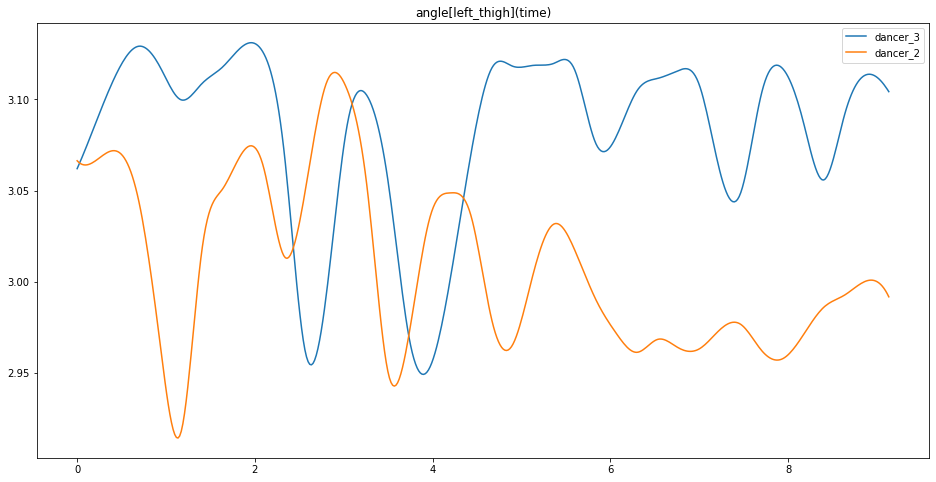

In [34]:
# let's compare two dancers' movement with respect to a certain limb:

limb_name = 'left_thigh'

# first of all, we should determine the timeline boundary;
# different dancers may have had different number of keypoints detected for a selected limb
# but only those limbs retain that were detected both on first and the last frame
# so we can pick any dancer to determine the timeline bounds:
#
x0 = dancers[0][limb_name].x[0]
x1 = dancers[0][limb_name].x[-1]

# dancers to compare:
#
dancer_1 = dancers[0]
dancer_2 = dancers[1]
dancer_3 = dancers[2]

X = np.linspace(x0, x1, 500)

plt.figure(figsize = (16, 8))

spline_points = lambda s: s(s.x)

plt.plot(X, dancer_3[limb_name](X), X, dancer_2[limb_name](X))

#plt.plot(dancer_1[limb_name].x, spline_points(dancer_1[limb_name]), 'o')
#plt.plot(dancer_2[limb_name].x, spline_points(dancer_2[limb_name]), 'o')

plt.legend(['dancer_3', 'dancer_2'])
plt.title('angle[' + limb_name + '](time)')
plt.show()

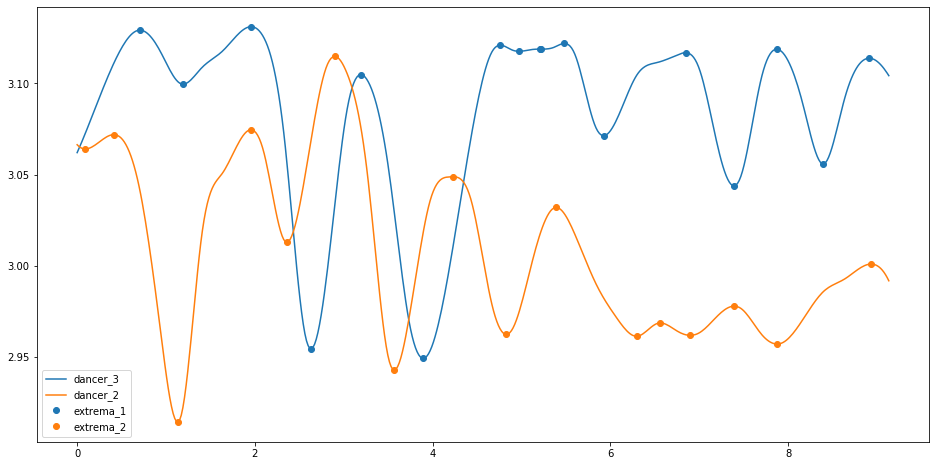

In [35]:
# extrema (aka roots of the derivative) are returned as a list of a function argument values
#
extrema_1 = dancer_3[limb_name].derivative().roots(extrapolate = False)
extrema_2 = dancer_2[limb_name].derivative().roots(extrapolate = False)

plt.figure(figsize = (16, 8))

p1 = plt.plot(X, dancer_3[limb_name](X))
p2 = plt.plot(X, dancer_2[limb_name](X))

plt.plot(extrema_1, dancer_3[limb_name](extrema_1), 'o', color = p1[0].get_color())
plt.plot(extrema_2, dancer_2[limb_name](extrema_2), 'o', color = p2[0].get_color())

plt.legend(['dancer_3', 'dancer_2', 'extrema_1', 'extrema_2'])
plt.show()

In [21]:
# finds mathing extrema of splines `a` and `b`;
# matching is based on:
#
#  1. extrema proximity
#  2. 'curvature' at extrema
#
def get_matching_extrema(a, b):

    da = a.derivative()
    db = b.derivative()

    extr_a = da.roots(extrapolate = False)
    extr_b = db.roots(extrapolate = False)

    # a rule of thumb is to try to match a smaller set of points
    # to a subset of a larger set of points
    #
    if len(extr_a) <= len(extr_b):
        ref_1 = extr_a
        ref_2 = extr_b

        c_1 = da.derivative()
        c_2 = db.derivative()
        
        swapped = False
    else:
        ref_1 = extr_b
        ref_2 = extr_a
        
        c_1 = db.derivative()
        c_2 = da.derivative()
        
        swapped = True

    # for each extremum `ref_1[k]` (where k = 0..len(ref_1)) try to find a match from `ref_2` such that:
    #
    #   1. the found extremum is in the range (ref_1[k-1]..ref_1[k+1])
    #      (assuming that asynchronicity is less than the interval between 2 melody beats)
    #
    #   2. the found extremum has the same 'curvature' sign as `ref_1[k]`
    #      (i.e. minimum should not be matched to a maximum)
    #
    #   3. if there are several points found satisfying the conditions above
    #      the closest to `ref_1[k]` is taken
    #
    
    extrema_1 = []
    extrema_2 = []
    
    # `ref_2` index
    p = 0
    
    p_min = 0
    
    for k in range(len(ref_1)):

        x0 = -np.inf if k == 0             else ref_1[k-1]
        x1 =  np.inf if k == len(ref_1)-1  else ref_1[k+1]

        # indices of match candidates
        cnd = []

        p = p_min
        while p < len(ref_2):
            
            # extremum too far away -> skipping
            if ref_2[p] < x0:
                p += 1
                continue

            # extremum out of range (x0, x1) -> stop searching
            if ref_2[p] > x1:
                break

            # extremum is in range (x0, x1) -> checking the 2-nd condition:
            #
            if np.sign(c_2(ref_2[p])) == np.sign(c_1(ref_1[k])):
                cnd.append(p)

            p += 1
        #end

        if len(cnd) != 0:

            extrema_1.append(ref_1[k])

            if len(cnd) > 1:
                # sorting candidates by proximity to `ref_1[k]`
                cnd.sort(key = lambda idx: abs(ref_2[idx] - ref_1[k]))

            extrema_2.append(ref_2[cnd[0]])
            p_min = cnd[0]
        #end
    #end

    if swapped:
        # 'unswap'
        return (np.array(extrema_2), np.array(extrema_1))
    else:
        return (np.array(extrema_1), np.array(extrema_2))


Let's test it:

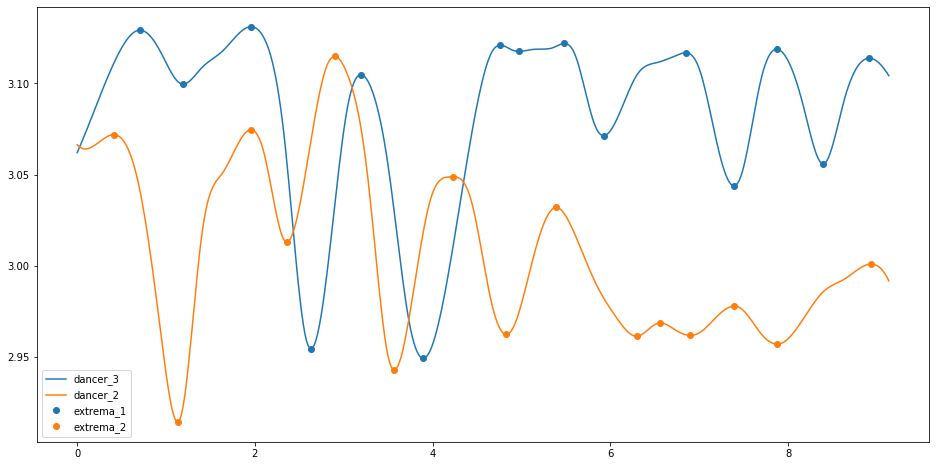

In [36]:
extrema_1, extrema_2 = get_matching_extrema(dancer_3[limb_name], dancer_2[limb_name])

plt.figure(figsize = (16, 8))

p1 = plt.plot(X, dancer_3[limb_name](X))
p2 = plt.plot(X, dancer_2[limb_name](X))

plt.plot(extrema_1, dancer_3[limb_name](extrema_1), 'o', color = p1[0].get_color())
plt.plot(extrema_2, dancer_2[limb_name](extrema_2), 'o', color = p2[0].get_color())

plt.legend(['dancer_3', 'dancer_2', 'extrema_1', 'extrema_2'])
plt.show()

Now both sets of extrema are of equal length and for any `k` `extrema_1[k]` corresponds to `extrema_2[k]`. Now we can subtract them directly and take average to get the delay estimation. However, it should be noted that there are still matching errors or errors in extrema location due to the noise/inconsistency in data so median showed to be more robust than average. You may experiment with different limbs and look how the results change *(note: thighs and legs turned out to be more reliable than arms and forearms)*:

In [62]:
print('Median delay:\t', 1000*np.median(extrema_2 - extrema_1), 'ms')
print('Average delay:\t', 1000*np.mean(extrema_2 - extrema_1), 'ms')

Median delay:	 -283.9754852320393 ms
Average delay:	 -226.4545443917123 ms


## 3. Pose synchronisity

To estimate the overall pose synchronicity we should, essentially, combine all the per-limb delays.

**Update: per-limb delay refined in order to suppress the wrong sign differences.**

In [58]:
# `signed_delay` specifies whether to differentiate positive and negative delays
#
def get_limb_delay(dancer_1, dancer_2, limb_name, signed_delay = True):

    # if `limb_name` is present in both dancers...
    if dancer_1[limb_name] is not None and dancer_2[limb_name] is not None:

        # ...calculate the corresponding delay
        extrema_1, extrema_2 = get_matching_extrema(dancer_1[limb_name], dancer_2[limb_name])

        de = extrema_2 - extrema_1

        if signed_delay:
            # separate delays by sign:
            de_pos = de[de > 0]
            de_neg = de[de < 0]

            # suppressing sign errors:
            # if one of the groups is smaller than a third of another group -> ignore it
            #
            if len(de_pos) < len(de_neg)/3:
                de = de_neg
            elif len(de_neg) < len(de_pos)/3:
                de = de_pos
            else:
                # otherwise it's just a mess
                return None
        else:
            de = np.abs(de)

        return np.median(de)

    else:
        
        if dancer_1[limb_name] is None:
            print("dancer_1 doesn't have a limb '{}'".format(limb_name))
        else:
            print("dancer_2 doesn't have a limb '{}'".format(limb_name))
    #end

    return None


def estimate_pose_synchronicity(dancer_1, dancer_2, signed_delay = True):

    delays = []

    print('Per-limb delays:\n')

    # (each dancer `limbs` containes a fixed set of limb names)
    for limb_name in dancer_1.limbs:

        dt = get_limb_delay(dancer_1, dancer_2, limb_name, signed_delay)

        if dt is not None:
            delays.append(dt)
            
            print('\t', limb_name, ':\t', 1000*dt, ' ms', sep = '')
        else:
            
            print('\t', limb_name, ':\t', '<undetermined>', sep = '')
    #end

    delays = np.array(delays)

    if signed_delay:
        # separating delays by sign and performing suppression (the same as in `get_limb_delay()`):

        delays_pos = delays[delays > 0]
        delays_neg = delays[delays < 0]

        if len(delays_pos) < len(delays_neg)/3:
            delays = delays_neg
        elif len(delays_neg) < len(delays_pos)/3:
            delays = delays_pos
        else:

            print("\nInconsistent limb delays: unable to determine synchronicity")
            return
    else:
        delays = np.abs(delays)

    print('\nOverall delay:\n')

    print('\t', 'median: \t', 1000*np.median(delays), ' ms', sep='')
    print('\t', 'average: \t', 1000*np.mean(delays), ' ms', sep='')

In [59]:
estimate_pose_synchronicity(dancer_1, dancer_2, True)

Per-limb delays:

	neck:	<undetermined>
	right_shoulder:	<undetermined>
	right_forearm:	<undetermined>
	right_arm:	<undetermined>
	right_thigh:	<undetermined>
	left_shoulder:	<undetermined>
	left_forearm:	<undetermined>
	left_arm:	<undetermined>
	left_thigh:	<undetermined>

Inconsistent limb delays: unable to determine synchronicity


In [44]:
estimate_pose_synchronicity(dancer_1, dancer_3, True)

Per-limb delays:

	neck:	<undetermined>
	right_shoulder:	<undetermined>
	right_forearm:	<undetermined>
	right_arm:	<undetermined>
	right_thigh:	<undetermined>
	left_shoulder:	<undetermined>
	left_forearm:	215.33577208263833 ms
	left_arm:	<undetermined>
	left_thigh:	<undetermined>

Overall delay:

	median: 	215.33577208263833 ms
	average: 	215.33577208263833 ms


In [45]:
estimate_pose_synchronicity(dancer_2, dancer_3, True)

Per-limb delays:

	neck:	<undetermined>
	right_shoulder:	<undetermined>
	right_forearm:	<undetermined>
	right_arm:	<undetermined>
	right_thigh:	<undetermined>
	left_shoulder:	<undetermined>
	left_forearm:	<undetermined>
	left_arm:	<undetermined>
	left_thigh:	294.20382092420726 ms

Overall delay:

	median: 	294.20382092420726 ms
	average: 	294.20382092420726 ms
